<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/davidc_hlt_studies_20251119_noduplicates_dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HLT Studies Nov 2025: Duplicates & Overlap Removal

__Author:__ Claire David  and  Raktim Mukherjee

__Date created:__ Nov 20, 2025  
__Goals:__
* Inspect duplicated objects in events
* Remove irrelevant events
* Create datasets for classification

__Subgoals:__
* Get new utils functions for a new repo

__Status:__  
* Duplicate removal works (need to tidy up)
* Need to code the Overlap Removal




In [1]:
import os

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from collections import defaultdict

## Mount GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Repository
Shortcut in Claire's Drive pointing to Raktim's repo:

In [3]:
repo='/content/drive/MyDrive/Datasets/ADdata'
!ls $repo

EB25_500306.h5
MC_ggF_H125_a16a16_4b_ctau10_filtered_470000.h5
MC_HAHMggf_470000.h5
MC_hh_bbbb_vbf_novhh_5fs_l1cvv1cv1_470000.h5
MC_HNLeemu_470000.h5
MC_HtoSUEP_470000.h5
MC_VBF_H125_a55a55_4b_ctau1_filtered_470000.h5
MC_Znunu_470000.h5


## Load Inputs
To put in future `utils/load_inputs.py`

In [4]:
def load_and_preprocess_datasets(base_dir):
    """
    Load all HDF5 files from a base directory and preprocess them into a
    standardized dataset dictionary.

    Steps performed:
    1. Load every .h5 file and store each file under a dataset tag.
    2. Remove EB24 samples.
    3. Rename EB25 sample to 'EB_test'.
    4. Convert trigger flags (HLT/L1) to boolean arrays.
    5. For MC samples:
         - add unit event weights
         - standardize tag names (strip MC_... parts)

    Args:
        base_dir (str): Path to the folder containing all HDF5 files.

    Returns:
        dict: A dictionary mapping dataset tags → dict of numpy arrays.
    """


    datasets = {} # dictionary of dictionaries, each dictionary is a dataset

    # ====== 1. Load the data ======
    # loop over all the files in the base directory
    for tag in os.listdir(base_dir):
        file_path = os.path.join(base_dir, tag)
        datasets[tag] = {}

        # load the data from the file
        with h5py.File(file_path, 'r') as hf:
            for key in hf.keys():
                datasets[tag][key] = hf[key][:]

    # ====== 2. Remove EB24 samples ======
    for tag in list(datasets.keys()):
        if tag.startswith("EB24"):
            del datasets[tag]

    # ====== 3. Rename EB25 to EB_test ======
    if "EB25_500306.h5" in datasets:
        datasets["EB_test"] = datasets.pop("EB25_500306.h5")

    # ====== 4. Convert trigger flags ======
    for tag, d in datasets.items():
        d["passHLT"] = (d["pass_HLT_unprescaled"] == 1)
        d["passL1"]  = (d["pass_L1_unprescaled"] == 1)
        del d["pass_HLT_unprescaled"]
        del d["pass_L1_unprescaled"]

    # ====== 5. Add MC weights ======
    for tag, d in datasets.items():
        if tag.startswith("MC"):
            d["weights"] = np.ones(len(d["run_numbers"]))

    # ====== 6. Normalize MC tag names ======
    original_tags = list(datasets.keys())

    for tag in original_tags:
        if tag.startswith("MC"):
            new_tag = tag.split("MC_")[1]
            new_tag = new_tag.split("_470000")[0]

            if new_tag == "hh":
                new_tag = "hh_bbbb_vbf_novhh_5fs_l1cvv1cv1"

            datasets[new_tag] = datasets.pop(tag)

    # ====== Sanity check ======
    total_events = sum(len(next(iter(d.values()))) for d in datasets.values())

    total_bytes = 0
    for d in datasets.values():
        for arr in d.values():
            total_bytes += arr.nbytes

    total_gb = total_bytes / (1024**3)

    print(f"[load_and_preprocess_datasets] Loaded {len(datasets)} datasets "
          f"({total_events:,} total events, ~{total_gb:.2f} GB)")

    return datasets


In [5]:
def print_shapes(datasets, tags=None):
    """
    Print the detailed shapes of arrays in selected datasets.

    Args:
        datasets (dict): Dictionary {tag -> dict of arrays}.
        tags (list or None): List of dataset tags to print. If None, print all.
    """
    if tags is None:
        tags = datasets.keys()

    for tag in tags:
        print(f"{tag}:")
        data_dict = datasets[tag]
        for key, value in data_dict.items():
            print(f"  {key}: {value.shape}")
        print()

In [6]:
datasets = load_and_preprocess_datasets(repo)

[load_and_preprocess_datasets] Loaded 8 datasets (1,487,586 total events, ~1.25 GB)


In [7]:
hlt_data_tags = [t for t in datasets if not t.startswith("MC")]
print("HLT data tags:")
for tag in hlt_data_tags:
    print(f" - {tag}")

HLT data tags:
 - EB_test
 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


In [8]:
hlt_data_all_tags = [t for t in datasets]
print("HLT data all tags:")
for tag in hlt_data_all_tags:
    print(f" - {tag}")

HLT data all tags:
 - EB_test
 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


In [9]:
print_shapes(datasets, ['EB_test', 'HAHMggf', 'HtoSUEP','Znunu'])

EB_test:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_L1AD: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
  passHLT: (1017586,)
  passL1: (1017586,)

HAHMggf:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_online: (100000,)
  passL1ADT_online: (100000,)
 

In [10]:
def build_dataframe(datasets, tags=None):
    """
    Build a combined HLT dataframe with weights and target labels.

    Args:
        datasets (dict): {tag -> dict of arrays}
        tags (list or None): list of tags to include; default = all

    Returns:
        pd.DataFrame: combined dataframe
    """
    if tags is None:
        tags = datasets.keys()

    # Hardcoded HLT_data column names
    columns = [
        'j0pt','j0eta','j0phi','j1pt','j1eta','j1phi',
        'j2pt','j2eta','j2phi','j3pt','j3eta','j3phi',
        'j4pt','j4eta','j4phi','j5pt','j5eta','j5phi',
        'e0pt','e0eta','e0phi','e1pt','e1eta','e1phi',
        'e2pt','e2eta','e2phi',
        'mu0pt','mu0eta','mu0phi','mu1pt','mu1eta','mu1phi',
        'mu2pt','mu2eta','mu2phi',
        'ph0pt','ph0eta','ph0phi','ph1pt','ph1eta','ph1phi',
        'ph2pt','ph2eta','ph2phi',
        'METpt','METeta','METphi'
    ]

    dfs = []
    for tag in tags:
        d = datasets[tag]
        df = pd.DataFrame(d['HLT_data'], columns=columns)

        # Event and run numbers:
        df['run_number'] = d['run_numbers']
        df['event_number'] = d['event_numbers']

        # Weights:
        df['weight'] = np.asarray(d['weights']).reshape(-1)
        df['target'] = tag

        # HLTAD scores:
        if 'HLT_AD_scores' in d:
            df['HLT_AD_scores'] = np

        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [11]:
hlt_df = build_dataframe(datasets)

In [12]:
hlt_df.head()

,j0pt,j0eta,j0phi,j1pt,j1eta,j1phi,j2pt,j2eta,j2phi,j3pt,...,ph2pt,ph2eta,ph2phi,METpt,METeta,METphi,run_number,event_number,weight,target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.009135,0.0,-1.915390,500306,1027130115,5.0,EB_test
1,23.893738,-0.032734,1.230678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.742011,0.0,-1.910914,500306,1027130405,5.0,EB_test
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,500306,1027120493,12.0,EB_test
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.936713,0.0,-0.541381,500306,1027150997,12.0,EB_test
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,500306,1027146367,5.0,EB_test


Note: Except for ```EB_test```, all the other classes have been weighted 1.0



### Some details of the dataset

```
My data is in a pandas dataframe, combined_hlt_df. 48 features and 1 target variable called 'target' and 1 column 'weight' containing weights for the respective events (rows).
target
EB_test                               1017586
HAHMggf                                100000
HNLeemu                                100000
HtoSUEP                                100000
VBF_H125_a55a55_4b_ctau1_filtered      100000
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1         50000
Znunu                                   10000
ggF_H125_a16a16_4b_ctau10_filtered      10000
Name: count, dtype: int64
```



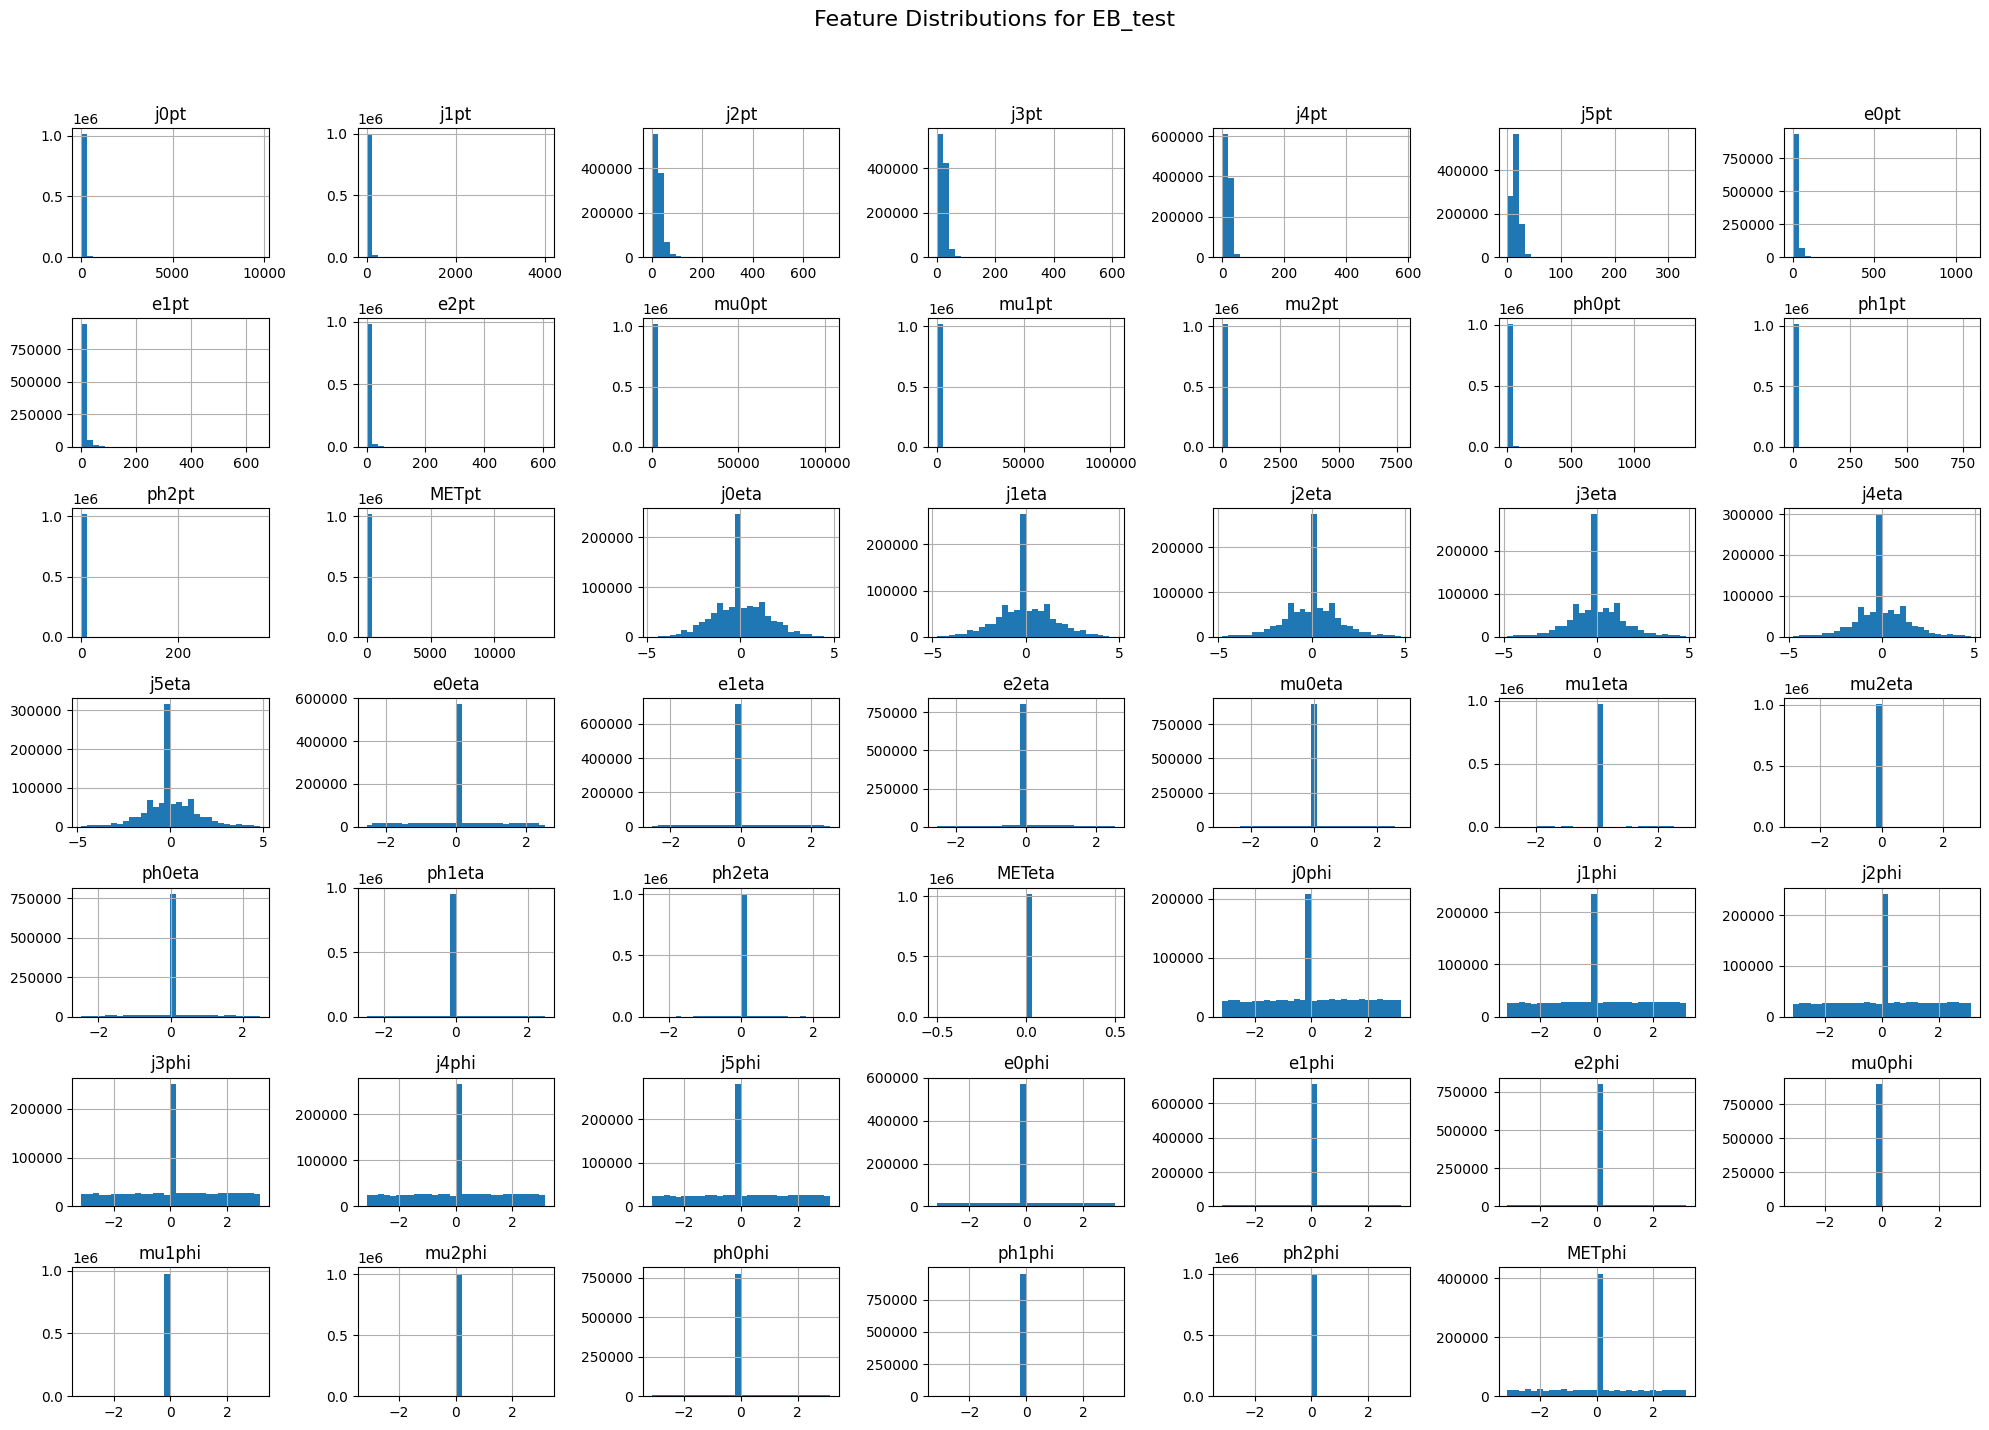

In [13]:
# Define the target name you want to filter by
target_name = 'EB_test'
filtered_df = hlt_df[hlt_df['target'] == target_name].drop(['target', 'weight', 'run_number','event_number'], axis=1)

# Filter data for the selected target
df_target = filtered_df

# Define feature groups based on name patterns
pt_cols = [c for c in df_target.columns if 'pt' in c]
eta_cols = [c for c in df_target.columns if 'eta' in c]
phi_cols = [c for c in df_target.columns if 'phi' in c]
# met_cols = [c for c in df_target.columns if 'MET' in c]
other_cols = ['weight'] if 'weight' in df_target.columns else []

# Combine in desired order
ordered_cols = pt_cols + eta_cols + phi_cols + other_cols

# Plot histograms grouped by type
df_target[ordered_cols].hist(
    figsize=(20, 15),
    bins=30,
)

plt.suptitle(f'Feature Distributions for {target_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [14]:
def print_tables_pt_ranges(dataframes, dataset_tag):
    """
    Print four tables showing pT ranges statistics (percentages) for a given dataset
    """
    # Filter the DataFrame for the specified dataset_tag in the 'target' column
    df = dataframes[dataframes['target'] == dataset_tag]
    # Correct column name from 'weights' to 'weight'
    total_weighted_events = df['weight'].sum()

    # Split columns into categories
    jet_cols = sorted([col for col in df.columns if col.startswith('j') and col.endswith('pt')])
    lepton_cols = sorted([col for col in df.columns if (col.startswith('e') or col.startswith('mu')) and col.endswith('pt')])
    photon_cols = sorted([col for col in df.columns if col.startswith('ph') and col.endswith('pt')])

    def print_subtable(columns, title, is_met=False):
        if not columns:
            return

        print(f"\n{title} pT ranges for {dataset_tag} (percentages)")
        print("-" * 100)

        # Header
        print(f"{'Range':<17}", end='')
        for col in columns:
            print(f"{col:<14}", end='')
        print("\n" + "-" * 100)

        if is_met:
            # Special ranges for MET
            ranges = ['MET < 0', 'MET = 0', 'MET = 0.001', '0.001 < MET < 50', 'MET ≥ 50']
            conditions = [
                lambda x: x < 0,
                lambda x: x == 0,
                lambda x: x == 0.001,
                lambda x: (x > 0.001) & (x < 50),
                lambda x: x >= 50
            ]
        else:
            # Standard ranges for other variables
            ranges = ['pt = 0', '0.1 < pt < 5', '5 < pt < 15', '15 < pt < 50', 'pt ≥ 50']
            conditions = [
                lambda x: x == 0,
                lambda x: (x > 0.1) & (x < 5),
                lambda x: (x >= 5) & (x < 15),
                lambda x: (x >= 15) & (x < 50),
                lambda x: x >= 50
            ]

        for range_text, condition in zip(ranges, conditions):
            print(f"{range_text:<12}", end='')
            for col in columns:
                weighted_sum = df[condition(df[col])]['weight'].sum()
                percentage = (weighted_sum / total_weighted_events) * 100
                print(f"{percentage:>8.1f}%     ", end='')
            print()

        print("-" * 100)

    # Print the three tables
    print_subtable(jet_cols, "Jets")
    print_subtable(lepton_cols, "Leptons")
    print_subtable(photon_cols, "Photons")
    print_subtable(['METpt'], "MET", is_met=True)

In [15]:
print_tables_pt_ranges(hlt_df, 'EB_test')


Jets pT ranges for EB_test (percentages)
----------------------------------------------------------------------------------------------------
Range            j0pt          j1pt          j2pt          j3pt          j4pt          j5pt          
----------------------------------------------------------------------------------------------------
pt = 0          15.8%         16.9%         18.7%         21.1%         24.1%         27.5%     
0.1 < pt < 5     0.0%          0.0%          0.0%          0.0%          0.0%          0.0%     
5 < pt < 15      0.8%          3.5%          8.9%         16.7%         25.4%         33.8%     
15 < pt < 50    80.3%         78.9%         72.3%         62.2%         50.5%         38.7%     
pt ≥ 50          3.1%          0.6%          0.1%          0.0%          0.0%          0.0%     
----------------------------------------------------------------------------------------------------

Leptons pT ranges for EB_test (percentages)
-----------------------

In [16]:
# Filter the DataFrame where METpt < 0
met_pt_negative = hlt_df[hlt_df['METpt'] < 0]

# Check if there are any negative METpt values to sample from
if not met_pt_negative.empty:
    # Sample 5 random values from the 'METpt' column
    # If there are fewer than 5 values, sample all available values
    num_samples = min(5, len(met_pt_negative))
    random_met_pt_values = met_pt_negative['METpt'].sample(n=num_samples, random_state=42)
    print("METpt values (METpt < 0):")
    for value in random_met_pt_values:
        print(f"{value:.2f}")
else:
    print("No METpt values less than 0 found in the dataframe.")

METpt values (METpt < 0):
-999.00
-999.00
-999.00
-999.00
-999.00


In [17]:
met_pt_negative_and_not_999 = hlt_df[(hlt_df['METpt'] < 0) & (hlt_df['METpt'] != -999.00)]

if not met_pt_negative_and_not_999.empty:
    print("Found METpt values less than 0 and not equal to -999.00.")
    print(met_pt_negative_and_not_999['METpt'].sample(min(10, len(met_pt_negative_and_not_999))).to_string())
else:
    print("No METpt values less than 0 and not equal to -999.00 were found.")

No METpt values less than 0 and not equal to -999.00 were found.


Our data shows no jets below 5 GeV and a very small fraction of photons and leptons in that range. Therefore 5 GeV is a suitable soft cut. It will be implemented after duplicate removal as it will simultaneously eliminate all zeros.

In [18]:
def check_all_pt_zero_events(df):
    # Identify all 'pt' columns
    pt_cols = [col for col in df.columns if col.endswith('pt')]

    # Create a boolean mask where all identified 'pt' columns are 0
    # Use .all(axis=1) to check if all conditions are True for each row
    all_pt_zero_mask = (df[pt_cols] == 0).all(axis=1)

    # Count the number of events where all pt values are 0
    num_all_pt_zero_events = all_pt_zero_mask.sum()

    return num_all_pt_zero_events

num_events_with_all_pt_zero = check_all_pt_zero_events(hlt_df)
print(f"Number of events where all objects' pT values are 0: {num_events_with_all_pt_zero:,}")

Number of events where all objects' pT values are 0: 140,869


## Event Display (Transverse View)

In [19]:
plt.rcParams.update({

    # Legend
    'legend.frameon': False,

    # Ticks
    'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 10,
        'ytick.major.size': 10,
        'xtick.minor.size': 5,
        'ytick.minor.size': 5,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.top': True,
        'ytick.right': True,
        'xtick.minor.visible': True,
        'ytick.minor.visible': True
})

In [20]:
def plot_event_2D(df, tag, event_idx):
    """
    Plot physics objects as 2D vectors in the transverse plane for a given event.
    Works with a combined dataframe that contains a 'target' column.

    Args:
        df (pd.DataFrame): combined HLT dataframe with 'target' and 'weight' columns.
        event_idx (int): index of the event within the selected dataset.
        tag (str): dataset tag to select (required).

    Returns:
        fig, ax: matplotlib figure and axes
    """
    # Filter dataframe by the selected tag
    df_tag = df[df['target'] == tag].reset_index(drop=True)

    if df_tag.empty:
        raise ValueError(f"Event ID not found for tag '{tag}'")

    df_event = df_tag.loc[event_idx]  # safe to use now

    fig, ax = plt.subplots(figsize=(6, 6), dpi=180)

    # Object types and indices
    obj_map = {
        'j': 5,   # jets: 0-5
        'e': 2,   # electrons: 0-2
        'mu': 2,  # muons: 0-2
        'ph': 2   # photons: 0-2
    }

    obj_styles = {
        'j': {'color': 'royalblue', 'label': 'Jets', 'width': 0.003},
        'e': {'color': 'red', 'label': 'Electrons', 'width': 0.003},
        'mu': {'color': 'green', 'label': 'Muons', 'width': 0.003},
        'ph': {'color': 'orange', 'label': 'Photons', 'width': 0.003},
        'MET': {'color': 'black', 'label': 'MET', 'width': 0.005}
    }

    max_pt = 0
    legend_elements = []  # Store legend entries
    groups_seen = set() # To add blank line after a particle type

    # --- Legend header + skip line ---
    leg_header = (
            f"Run Number: {df_event['run_number']}  |  "
            f"Event Number: {df_event['event_number']}"
        )
    legend_elements.append(
        plt.Line2D([0], [0], linestyle='', label=leg_header)
    )
    legend_elements.append(plt.Line2D([0], [0], linestyle='', alpha=0, label=''))

    # --- Plot particles ---
    for prefix, max_idx in obj_map.items():
        style = obj_styles[prefix]
        object_info = []

        for i in range(max_idx + 1):
            pt_col  = f'{prefix}{i}pt'
            eta_col = f'{prefix}{i}eta'
            phi_col = f'{prefix}{i}phi'

            if pt_col not in df.columns or phi_col not in df.columns or eta_col not in df.columns:
                continue

            pt  = df_event[pt_col]
            eta = df_event[eta_col]
            phi = df_event[phi_col]

            if pt <= 0.001:
                continue

            object_info.append((pt, eta, phi))
            max_pt = max(max_pt, pt)

            x = pt * np.cos(phi)
            y = pt * np.sin(phi)
            ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1,
                      color=style['color'], width=style['width'])

        if object_info:

            if groups_seen: # new particle type: blank line before
                legend_elements.append(
                    plt.Line2D([0], [0], linestyle='', alpha=0, label='')
                )
            groups_seen.add(prefix)

            # Add group title (Jets / Electrons / Muons / Photons)
            legend_elements.append(
                plt.Line2D([0], [0], color=style['color'], label=style['label'])
            )

            for pt, eta, phi in sorted(object_info, reverse=True):
                legend_elements.append(
                    plt.Line2D(
                        [0], [0], color=style['color'], linestyle='',
                        label = (
                            fr'$p_T$ = {pt:<6.1f}    '
                            fr'$\eta$ = {eta:<6.3f}    '
                            fr'$\phi$ = {phi:<6.3f}'
                        )
                    )
                )

    # --- MET ---
    if 'METpt' in df.columns and df_event['METpt'] > 0.001:
        pt, phi = df_event['METpt'], df_event['METphi']
        max_pt = max(max_pt, pt)
        style = obj_styles['MET']
        x = pt * np.cos(phi)
        y = pt * np.sin(phi)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1,
                  color=style['color'], width=style['width'])

        legend_elements.append(plt.Line2D([0], [0], linestyle='', alpha=0, label=''))
        legend_elements.append(
            plt.Line2D([0], [0], color=style['color'], label=style['label'])
        )
        legend_elements.append(
            plt.Line2D([0], [0], color=style['color'], linestyle='',
                       label = fr'$p_T$ = {pt:<6.1f}    $\phi$ = {phi:<6.3f}'
            )
        )

    # --- Plot settings ---
    ax.set_aspect('equal', adjustable='box')
    limit = max_pt * 1.2
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)

    # ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.2)

    # Add circular guidelines with round numbers
    max_radius = int(np.ceil(max_pt))
    step = 20 if max_radius > 100 else 10
    circles = np.arange(step, max_radius + step, step)  # Create array of round numbers

    for radius in circles:
        circle = plt.Circle((0, 0), radius, fill=False, linestyle='--',
                          alpha=0.2, color='gray')
        ax.add_artist(circle)
        ax.text(radius*np.cos(np.pi/4), radius*np.sin(np.pi/4),
                f'{radius:.0f} GeV', fontsize=8, alpha=0.5)

    ax.set_xlabel(r'$p_T \,\cos(\phi)$ [GeV]')
    ax.set_ylabel(r'$p_T \,\sin(\phi)$ [GeV]')
    ax.set_title("Transverse View")

    plt.tight_layout()
    legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1.06, 1.05), loc='upper left')
    legend.get_texts()[0].set_fontsize(12)   # header only bigger

    plt.subplots_adjust(right=0.75)

    return fig, ax

## Event Dump

In [21]:
def print_event_ordered(df, tag, event_idx=None, run_number=None, event_number=None):
    """
    Print event information either by df index or by (run_number, event_number).

    Exactly one of the following must be provided:
      - event_idx
      - run_number + event_number
    """
    # Filter by tag
    df_tag = df[df['target'] == tag].reset_index(drop=True)
    if df_tag.empty:
        print(f"No events found for tag '{tag}'")
        return

    # --- argument validation ---
    if event_idx is not None and (run_number is not None or event_number is not None):
        raise ValueError("Provide EITHER event_idx OR (run_number + event_number), not both.")

    if event_idx is None and (run_number is None or event_number is None):
        raise ValueError("Provide either event_idx OR both run_number and event_number.")

    # --- select by event_idx ---
    if event_idx is not None:
        df_event = df_tag.iloc[event_idx]

        print(f"Selected by event_idx = {event_idx}")
        print(f"Run Number   = {df_event['run_number']}")
        print(f"Event Number = {df_event['event_number']}")

    else:
        # --- select by run_number + event_number ---
        mask = (
            (df_tag['run_number'] == run_number) &
             (df_tag['event_number'] == event_number)
        )
        matches = df_tag[mask]

        if len(matches) == 0:
            raise ValueError(
                f"No event found with run_number={run_number} and event_number={event_number}."
            )
        elif len(matches) > 1:
            print("Warning: multiple matches — unexpected.")

        df_event = matches.iloc[0]

        print(f"Selected by run_number={run_number}, event_number={event_number}")
        print(f"  df index     = {df_event.name}")

    # Define object type order
    obj_order = ['j', 'e', 'mu', 'ph', 'MET']

    # Gather all pt columns by object type
    pt_cols_by_type = {obj: [] for obj in obj_order}

    for col in df_tag.columns:
        if col.endswith('pt'):
            base = col[:-2]
            for obj in obj_order:
                if base.startswith(obj):
                    pt_cols_by_type[obj].append(col)
                    break
            else:
                # catch any other object types if needed
                pass

    # Print header
    print(f"\nDataset {tag}, Event {event_idx}:")
    print("-" * 55)
    print(f"{'Object':<15} {'pT [GeV]':>10} {'η':>10} {'φ':>10}")
    print("-" * 55)

    # Loop over object types in order
    for obj in obj_order:
        for pt_col in sorted(pt_cols_by_type[obj]):
            base_name = pt_col[:-2]
            eta_col = base_name + 'eta'
            phi_col = base_name + 'phi'

            pt = df_event[pt_col]
            eta = df_event[eta_col] if eta_col in df_tag.columns else float('nan')
            phi = df_event[phi_col] if phi_col in df_tag.columns else float('nan')

            # Skip near-zero pT objects
            # if pt <= 0.001 and obj != 'MET':
            #     continue

            print(f"{base_name:<15} {pt:>10.1f} {eta:>10.3f} {phi:>10.3f}")

    print("-" * 55)

    # Optional: print weight / score
    if 'weights' in df_tag.columns:
        print(f"Event weight: {df_event['weights']:.3f}")
    if 'HLT_AD_scores' in df_tag.columns:
        print(f"HLT AD score: {df_event['HLT_AD_scores']:.1f}")


## Checking events

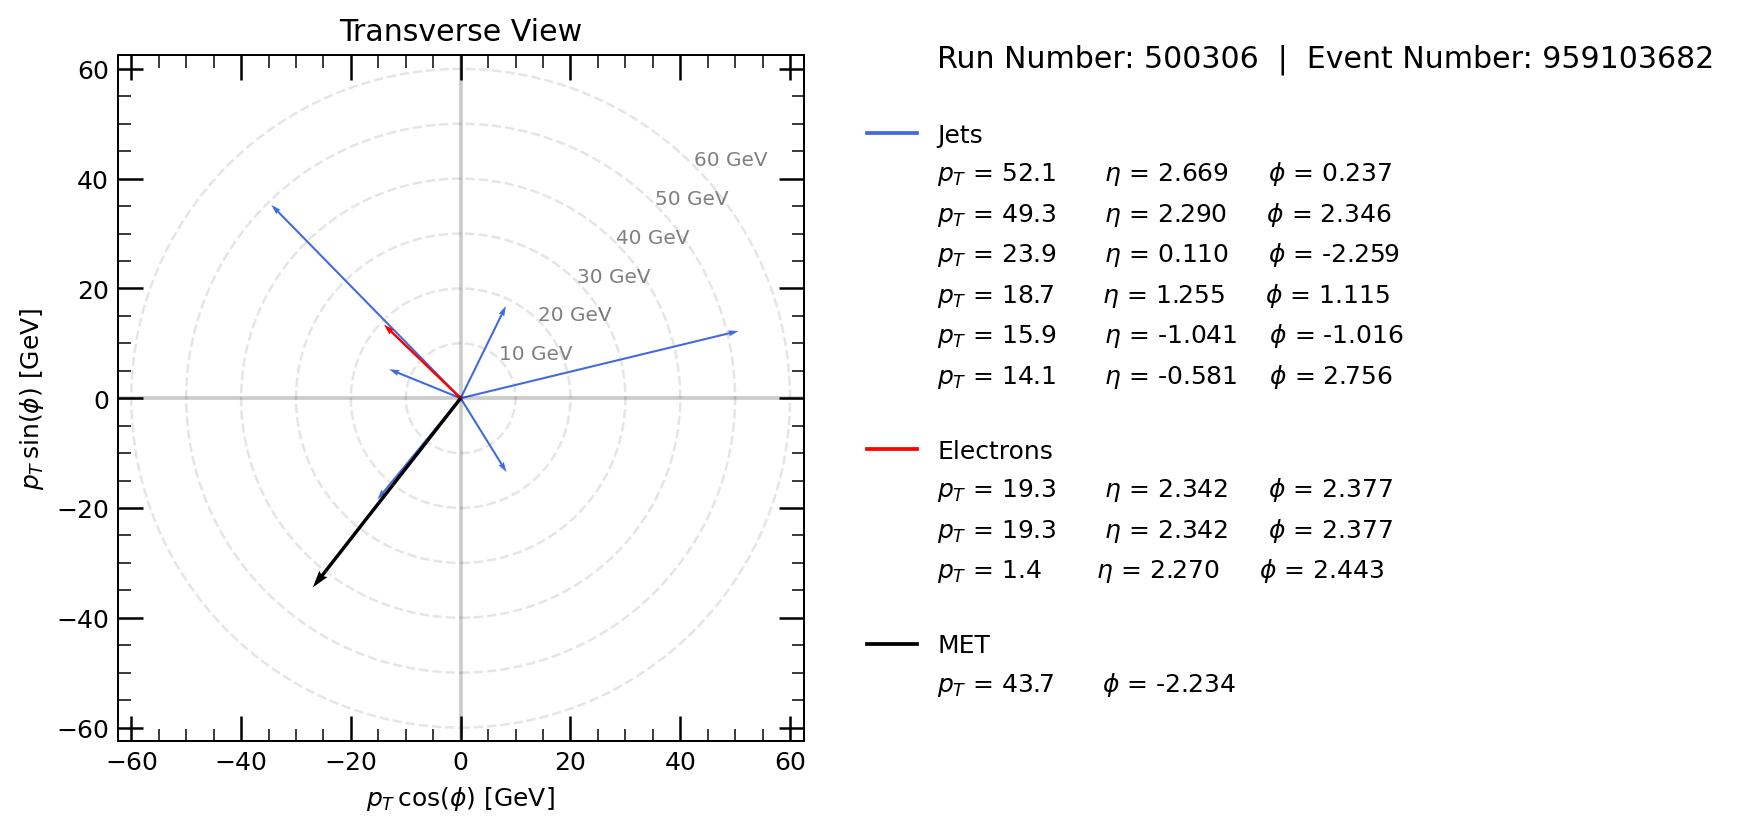

In [22]:
fix, ax = plot_event_2D(hlt_df, 'EB_test', event_idx=10123)

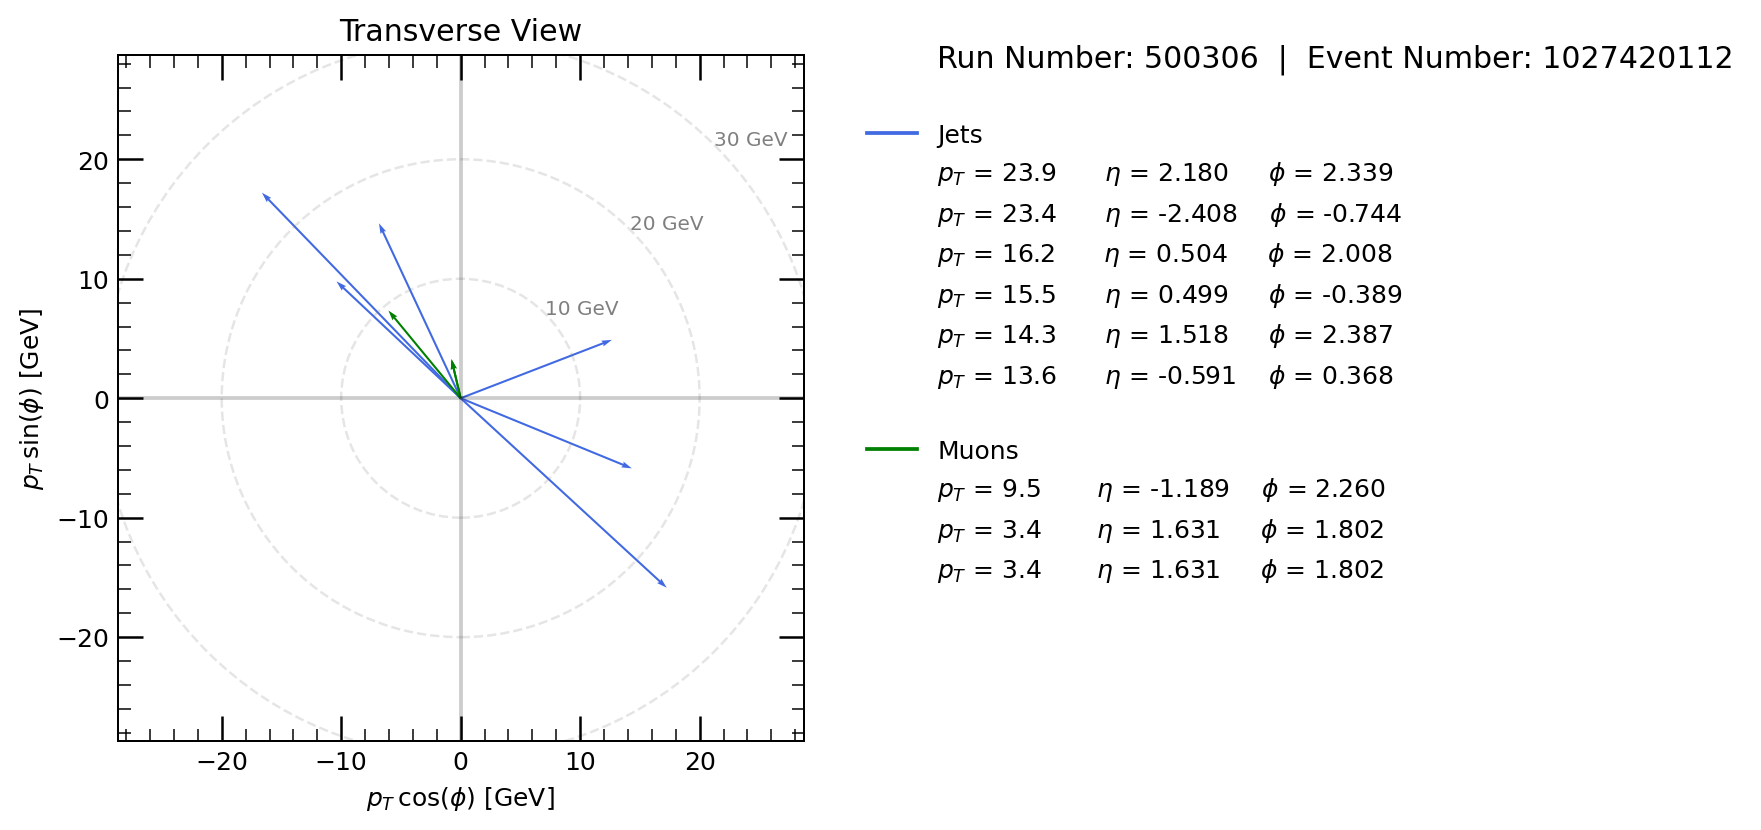

In [23]:
fix, ax = plot_event_2D(hlt_df, 'EB_test', event_idx=101)

## Duplicate Removal

In [24]:
def remove_duplicates_per_event(df, tag):
    """
    Remove duplicate physics objects in each event for a given tag
    Shift remaining objects up (zero padded)

    Args:
        df (pd.DataFrame): original dataframe with all events
        tag (str): value of the 'target' column to select events

    Returns:
        df_cleaned (pd.DataFrame): cleaned dataframe with duplicates removed
    """
    # --- Configuration ---
    obj_map = {'j':5, 'e':2, 'mu':2, 'ph':2}  # max indices
    obj_types = obj_map.keys()

    # Filter dataframe by tag
    df_clean = df[df['target'] == tag].copy().reset_index(drop=True)

    if df_clean.empty:
        raise ValueError(f"No events found for tag '{tag}'")

    # Prepare counters
    events_with_duplicates = defaultdict(int)
    raw_count = defaultdict(int)
    unique_count = defaultdict(int)

    # Iterate over events
    for idx, row in df_clean.iterrows():

        # --- Progress indicator ---
        if idx % 20000 == 0:
            print(f"Processing event {idx+1:,} / {len(df_clean):,} ...")

        for obj in obj_types:
            max_idx = obj_map[obj]

            # Collect current object values
            objs = []
            for i in range(max_idx + 1):
                pt = row[f'{obj}{i}pt']
                eta = row[f'{obj}{i}eta']
                phi = row[f'{obj}{i}phi']
                objs.append((pt, eta, phi))

            # Count raw
            raw_count[obj] += sum(1 for o in objs if o != (0.0, 0.0, 0.0))

            # Identify duplicates (keep first occurrence)
            seen = set()
            unique_objs = []
            duplicates_found = False
            for o in objs:
                if o == (0.0, 0.0, 0.0):
                    continue  # skip zero objects entirely
                if o in seen:
                    duplicates_found = True
                    continue
                seen.add(o)
                unique_objs.append(o)

            if duplicates_found:
                events_with_duplicates[obj] += 1

            unique_count[obj] += len(unique_objs)

            # Shift objects up and pad with zeros
            padded_objs = unique_objs + [(0.0, 0.0, 0.0)] * (len(objs) - len(unique_objs))

            # Write back to dataframe
            for i, (pt, eta, phi) in enumerate(padded_objs):
                df_clean.at[idx, f'{obj}{i}pt'] = pt
                df_clean.at[idx, f'{obj}{i}eta'] = eta
                df_clean.at[idx, f'{obj}{i}phi'] = phi

    # --- Summary ---
    total_events = len(df_clean)
    print(f"\nDataset {tag}, {total_events:,} events total\n")

    print(f"{'Object':<12} {'# raw':>12} {'# unique':>12} {'# duplicates':>14} {'% duplicates':>14}")
    print("-" * 70)

    for obj in obj_types:
        raw = raw_count[obj]
        unique = unique_count[obj]
        dup_removed = raw - unique
        perc = (dup_removed / raw * 100) if raw > 0 else 0.0

        print(
            f"{obj:<12}"
            f"{raw:>12,}"
            f"{unique:>12,}"
            f"{dup_removed:>14,}"
            f"{perc:>13.1f}%"
        )

    return df_clean


In [25]:
hlt_df_no_dupl = {}
hlt_df_no_dupl['HAHMggf'] = remove_duplicates_per_event(hlt_df, 'HAHMggf')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HAHMggf, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                571,435     571,435             0          0.0%
e                196,043     129,771        66,272         33.8%
mu                81,373      78,174         3,199          3.9%
ph               168,141     111,939        56,202         33.4%


In [26]:
hlt_df_no_dupl['HNLeemu'] = remove_duplicates_per_event(hlt_df, 'HNLeemu')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HNLeemu, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                570,261     570,261             0          0.0%
e                208,719     132,400        76,319         36.6%
mu                42,071      39,879         2,192          5.2%
ph               196,748     125,688        71,060         36.1%


In [27]:
hlt_df_no_dupl['HtoSUEP'] = remove_duplicates_per_event(hlt_df, 'HtoSUEP')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset HtoSUEP, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                582,127     582,127             0          0.0%
e                132,716     117,140        15,576         11.7%
mu                 4,555       4,154           401          8.8%
ph                40,842      39,792         1,050          2.6%


In [28]:
hlt_df_no_dupl['VBF_H125_a55a55_4b_ctau1_filtered'] = remove_duplicates_per_event(hlt_df, 'VBF_H125_a55a55_4b_ctau1_filtered')

Processing event 1 / 100,000 ...
Processing event 20,001 / 100,000 ...
Processing event 40,001 / 100,000 ...
Processing event 60,001 / 100,000 ...
Processing event 80,001 / 100,000 ...

Dataset VBF_H125_a55a55_4b_ctau1_filtered, 100,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                594,731     594,731             0          0.0%
e                251,421     201,108        50,313         20.0%
mu                36,433      34,276         2,157          5.9%
ph                61,312      57,340         3,972          6.5%


In [29]:
hlt_df_no_dupl['Znunu'] = remove_duplicates_per_event(hlt_df, 'Znunu')

Processing event 1 / 10,000 ...

Dataset Znunu, 10,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                 58,627      58,627             0          0.0%
e                 25,659      19,705         5,954         23.2%
mu                 2,445       2,266           179          7.3%
ph                 5,108       4,759           349          6.8%


In [30]:
hlt_df_no_dupl['ggF_H125_a16a16_4b_ctau10_filtered'] = remove_duplicates_per_event(hlt_df, 'ggF_H125_a16a16_4b_ctau10_filtered')

Processing event 1 / 10,000 ...

Dataset ggF_H125_a16a16_4b_ctau10_filtered, 10,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                 59,220      59,220             0          0.0%
e                 29,259      20,825         8,434         28.8%
mu                 4,818       4,148           670         13.9%
ph                 5,990       5,496           494          8.2%


In [31]:
hlt_df_no_dupl['hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'] = remove_duplicates_per_event(hlt_df, 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1')

Processing event 1 / 50,000 ...
Processing event 20,001 / 50,000 ...
Processing event 40,001 / 50,000 ...

Dataset hh_bbbb_vbf_novhh_5fs_l1cvv1cv1, 50,000 events total

Object              # raw     # unique   # duplicates   % duplicates
----------------------------------------------------------------------
j                299,333     299,333             0          0.0%
e                143,997     111,207        32,790         22.8%
mu                25,114      23,581         1,533          6.1%
ph                34,265      31,363         2,902          8.5%


In [32]:
hlt_df_no_dupl['EB_test'] = remove_duplicates_per_event(hlt_df, 'EB_test')

Processing event 1 / 1,017,586 ...
Processing event 20,001 / 1,017,586 ...
Processing event 40,001 / 1,017,586 ...
Processing event 60,001 / 1,017,586 ...
Processing event 80,001 / 1,017,586 ...
Processing event 100,001 / 1,017,586 ...
Processing event 120,001 / 1,017,586 ...
Processing event 140,001 / 1,017,586 ...
Processing event 160,001 / 1,017,586 ...
Processing event 180,001 / 1,017,586 ...
Processing event 200,001 / 1,017,586 ...
Processing event 220,001 / 1,017,586 ...
Processing event 240,001 / 1,017,586 ...
Processing event 260,001 / 1,017,586 ...
Processing event 280,001 / 1,017,586 ...
Processing event 300,001 / 1,017,586 ...
Processing event 320,001 / 1,017,586 ...
Processing event 340,001 / 1,017,586 ...
Processing event 360,001 / 1,017,586 ...
Processing event 380,001 / 1,017,586 ...
Processing event 400,001 / 1,017,586 ...
Processing event 420,001 / 1,017,586 ...
Processing event 440,001 / 1,017,586 ...
Processing event 460,001 / 1,017,586 ...
Processing event 480,001 /

In [33]:
print_event_ordered(hlt_df, tag='EB_test', event_idx=101)

Selected by event_idx = 101
Run Number   = 500306
Event Number = 1027420112

Dataset EB_test, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    23.9      2.180      2.339
j1                    23.4     -2.408     -0.744
j2                    16.2      0.504      2.008
j3                    15.5      0.499     -0.389
j4                    14.3      1.518      2.387
j5                    13.6     -0.591      0.368
e0                     0.0      0.000      0.000
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    9.5     -1.189      2.260
mu1                    3.4      1.631      1.802
mu2                    3.4      1.631      1.802
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.000

In [34]:
print_event_ordered(hlt_df_no_dupl['EB_test'], tag='EB_test', event_idx=101)

Selected by event_idx = 101
Run Number   = 500306
Event Number = 1027420112

Dataset EB_test, Event 101:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    23.9      2.180      2.339
j1                    23.4     -2.408     -0.744
j2                    16.2      0.504      2.008
j3                    15.5      0.499     -0.389
j4                    14.3      1.518      2.387
j5                    13.6     -0.591      0.368
e0                     0.0      0.000      0.000
e1                     0.0      0.000      0.000
e2                     0.0      0.000      0.000
mu0                    9.5     -1.189      2.260
mu1                    3.4      1.631      1.802
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.000

In [35]:
print_event_ordered(hlt_df, tag='EB_test', event_idx=10123)

Selected by event_idx = 10123
Run Number   = 500306
Event Number = 959103682

Dataset EB_test, Event 10123:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    52.1      2.669      0.237
j1                    49.3      2.290      2.346
j2                    23.9      0.110     -2.259
j3                    18.7      1.255      1.115
j4                    15.9     -1.041     -1.016
j5                    14.1     -0.581      2.756
e0                    19.3      2.342      2.377
e1                    19.3      2.342      2.377
e2                     1.4      2.270      2.443
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.

In [36]:
print_event_ordered(hlt_df_no_dupl['EB_test'], tag='EB_test', event_idx=10123)

Selected by event_idx = 10123
Run Number   = 500306
Event Number = 959103682

Dataset EB_test, Event 10123:
-------------------------------------------------------
Object            pT [GeV]          η          φ
-------------------------------------------------------
j0                    52.1      2.669      0.237
j1                    49.3      2.290      2.346
j2                    23.9      0.110     -2.259
j3                    18.7      1.255      1.115
j4                    15.9     -1.041     -1.016
j5                    14.1     -0.581      2.756
e0                    19.3      2.342      2.377
e1                     1.4      2.270      2.443
e2                     0.0      0.000      0.000
mu0                    0.0      0.000      0.000
mu1                    0.0      0.000      0.000
mu2                    0.0      0.000      0.000
ph0                    0.0      0.000      0.000
ph1                    0.0      0.000      0.000
ph2                    0.0      0.000      0.

 - HAHMggf
 - HNLeemu
 - HtoSUEP
 - VBF_H125_a55a55_4b_ctau1_filtered
 - Znunu
 - ggF_H125_a16a16_4b_ctau10_filtered
 - hh_bbbb_vbf_novhh_5fs_l1cvv1cv1

### Next steps:


1.   ~~Select events which have the $p_T$ for jets, $\gamma$, $e$, $\mu$ > 5 GeV~~
2. Compare the histograms before and after duplicate removal
3.   Plot jet kinematic distributions
4. Make a comparison between the distribution of different weighted events
5. Sample proportional to the weights
6. **Save the dataframe**
-----------------------------------------------------
7. Check the classification accuracy using Random Forest for different pT thresholds
8. Divide dataset into different pT bins (upper limit at 80 GeV?)
9. More classification tests for different signals and different pT ranges





**How does the filtering take place in the following cell?**

1. If all the pt columns have 0.0, then the event is discarded
2. If METpt = -999.00, then the event is discarded

In [37]:
hlt_df_filtered_pt_cut = {}
pt_threshold_for_objects = 5.0 # This threshold is now specific to the object pT condition

# Define prefixes for objects whose pT needs to be checked
object_prefixes = ['j', 'e', 'mu', 'ph']

for tag, df_original in hlt_df_no_dupl.items(): # Renamed to df_original for clarity
    print(f"Filtering dataset: {tag}")

    # Create a list of all object pT columns to check (excluding METpt)
    pt_columns_for_objects = []
    for prefix in object_prefixes:
        for col in df_original.columns:
            if col.startswith(prefix) and col.endswith('pt'):
                pt_columns_for_objects.append(col)

    # Handle cases where no object pT columns are found (though unlikely with this dataset)
    actual_pt_cols_for_objects = [col for col in pt_columns_for_objects if col in df_original.columns]

    if not actual_pt_cols_for_objects:
        # If no object pT columns, then no 'pt_violation' can occur from these objects
        has_any_obj_pt_violation = pd.Series(False, index=df_original.index)
    else:
        # Create a mask where individual object pT is > 0 and < pt_threshold_for_objects
        individual_pt_violation_mask = (df_original[actual_pt_cols_for_objects] > 0) & \
                                       (df_original[actual_pt_cols_for_objects] < pt_threshold_for_objects)
        # Check if ANY of these individual object pT violations are True for each event
        has_any_obj_pt_violation = individual_pt_violation_mask.any(axis=1)

    # Define the final keep mask based on the complex logic:
    # An event is kept if:
    # 1. METpt > 0
    # OR
    # 2. (METpt is NOT -999.00 AND has_any_obj_pt_violation is False)
    #    This covers cases where (METpt == 0 AND no pt_violation) OR (METpt < 0 but not -999 AND no pt_violation)
    final_keep_mask = (df_original['METpt'] > 0) | \
                      ((df_original['METpt'] != -999.00) & (~has_any_obj_pt_violation))

    filtered_df = df_original[final_keep_mask].copy()
    print(f"  Original events: {len(df_original):,}, Filtered events: {len(filtered_df):,}")
    hlt_df_filtered_pt_cut[tag] = filtered_df

print("\nFiltered DataFrames created in 'hlt_df_filtered_pt_cut' with updated logic.")

Filtering dataset: HAHMggf
  Original events: 100,000, Filtered events: 78,253
Filtering dataset: HNLeemu
  Original events: 100,000, Filtered events: 62,861
Filtering dataset: HtoSUEP
  Original events: 100,000, Filtered events: 32,069
Filtering dataset: VBF_H125_a55a55_4b_ctau1_filtered
  Original events: 100,000, Filtered events: 84,407
Filtering dataset: Znunu
  Original events: 10,000, Filtered events: 9,217
Filtering dataset: ggF_H125_a16a16_4b_ctau10_filtered
  Original events: 10,000, Filtered events: 8,320
Filtering dataset: hh_bbbb_vbf_novhh_5fs_l1cvv1cv1
  Original events: 50,000, Filtered events: 40,929
Filtering dataset: EB_test
  Original events: 1,017,586, Filtered events: 988,578

Filtered DataFrames created in 'hlt_df_filtered_pt_cut' with updated logic.


In [38]:
print("\n--- pT Ranges for All Filtered Signal Datasets Combined ---")

# Create a combined dataframe for all filtered signals
# Note: Assuming 'hlt_df_filtered_pt_cut' already exists and contains the filtered dataframes
filtered_signal_dfs_combined = [df for tag, df in hlt_df_filtered_pt_cut.items() if tag != 'EB_test']
combined_filtered_signals_df = pd.concat(filtered_signal_dfs_combined, ignore_index=True)
combined_filtered_signals_df['target'] = 'All filtered signals combined'

# Call the function for the newly created combined filtered signals dataframe
print_tables_pt_ranges(combined_filtered_signals_df, 'All filtered signals combined')


--- pT Ranges for All Filtered Signal Datasets Combined ---

Jets pT ranges for All filtered signals combined (percentages)
----------------------------------------------------------------------------------------------------
Range            j0pt          j1pt          j2pt          j3pt          j4pt          j5pt          
----------------------------------------------------------------------------------------------------
pt = 0           0.1%          0.4%          1.2%          2.3%          3.7%          5.5%     
0.1 < pt < 5     0.0%          0.0%          0.0%          0.0%          0.0%          0.0%     
5 < pt < 15      0.0%          0.3%          1.3%          3.5%          7.3%         13.0%     
15 < pt < 50    20.6%         49.2%         67.5%         80.8%         84.9%         80.5%     
pt ≥ 50         79.2%         50.1%         30.0%         13.4%          4.1%          1.0%     
--------------------------------------------------------------------------------------

In [39]:
print_tables_pt_ranges(hlt_df_filtered_pt_cut['EB_test'], 'EB_test')


Jets pT ranges for EB_test (percentages)
----------------------------------------------------------------------------------------------------
Range            j0pt          j1pt          j2pt          j3pt          j4pt          j5pt          
----------------------------------------------------------------------------------------------------
pt = 0          16.3%         17.4%         19.3%         21.7%         24.7%         28.2%     
0.1 < pt < 5     0.0%          0.0%          0.0%          0.0%          0.0%          0.0%     
5 < pt < 15      0.8%          3.5%          9.0%         16.7%         25.4%         33.9%     
15 < pt < 50    79.8%         78.4%         71.7%         61.6%         49.8%         38.0%     
pt ≥ 50          3.2%          0.7%          0.1%          0.0%          0.0%          0.0%     
----------------------------------------------------------------------------------------------------

Leptons pT ranges for EB_test (percentages)
-----------------------

In [40]:
print("\nEvent Counts Comparison (Original vs. Filtered by 5 GeV pT cut):\n")

# Column widths (tweak if needed)
col1 = 40   # dataset name
col2 = 18   # original events
col3 = 18   # filtered events
col4 = 12   # % retained

# Header
print(f"{'Dataset':<{col1}}{'Original Events':>{col2}}{'Filtered Events':>{col3}}{'% Retained':>{col4}}")
print("-" * (col1 + col2 + col3 + col4))

# Rows
for tag in hlt_df_no_dupl.keys():
    original_count = len(hlt_df_no_dupl[tag])
    filtered_count = len(hlt_df_filtered_pt_cut[tag])
    pct = (filtered_count / original_count * 100) if original_count else 0

    print(
        f"{tag:<{col1}}"
        f"{original_count:>{col2},}"
        f"{filtered_count:>{col3},}"
        f"{pct:>{col4}.2f}%"
    )



Event Counts Comparison (Original vs. Filtered by 5 GeV pT cut):

Dataset                                    Original Events   Filtered Events  % Retained
----------------------------------------------------------------------------------------
HAHMggf                                            100,000            78,253       78.25%
HNLeemu                                            100,000            62,861       62.86%
HtoSUEP                                            100,000            32,069       32.07%
VBF_H125_a55a55_4b_ctau1_filtered                  100,000            84,407       84.41%
Znunu                                               10,000             9,217       92.17%
ggF_H125_a16a16_4b_ctau10_filtered                  10,000             8,320       83.20%
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1                     50,000            40,929       81.86%
EB_test                                          1,017,586           988,578       97.15%


It is important to note that a significant fraction of the discarded events have null values as can be seen from cells [a](https://colab.research.google.com/drive/15RzUelBWqd7Ijf9j61WMbfaNJiggfxxA#scrollTo=7qS9DpvsHwjt&line=1&uniqifier=1) and [b](https://colab.research.google.com/drive/15RzUelBWqd7Ijf9j61WMbfaNJiggfxxA#scrollTo=po0gbgyOHwhc&line=2&uniqifier=1)


In [41]:
import matplotlib as mpl

def plot_jet_pt_comparison(filtered_dataframes, jet_indices=[0, 1], log_y=False):
    """
    Plots pT distributions for specified leading jets, comparing different
    datasets on the same plot. Uses log-spaced bins and ATLAS-style log ticks.
    """

    all_tags = list(filtered_dataframes.keys())

    # Color map (same as before)
    colors = plt.get_cmap('tab10', len(all_tags))

    # Log-spaced bins for steep pT spectrum
    bin_edges = np.logspace(np.log10(5), np.log10(950), 80)

    # ATLAS-style ticks
    atlas_ticks = [5, 10, 20, 30, 50, 70, 100, 150, 200, 300, 450, 600, 900]

    for j_idx in jet_indices:
        fig, ax = plt.subplots(figsize=(12, 6), dpi=130)

        jet_pt_col = f"j{j_idx}pt"

        for k, tag in enumerate(all_tags):
            df = filtered_dataframes[tag]
            data = df[df[jet_pt_col] > 5][jet_pt_col]  # avoid log(0)

            ax.hist(
                data,
                bins=bin_edges,
                density=True,
                histtype="step",
                linewidth=1.5,
                color=colors(k),
                label=tag
            )

        # ----- Fix the x-axis (ATLAS style) -----
        ax.set_xscale("log")
        ax.set_xlim(5, 950)
        ax.set_xticks(atlas_ticks)
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.tick_params(axis="x", which="major", length=7)

        # ----- y-axis -----
        if log_y:
            ax.set_yscale("log")

        # Titles and labels
        ax.set_title(f'Jet {j_idx} $p_T$ Distribution Comparison for All Datasets')
        ax.set_xlabel('$p_T$ [GeV]')
        ax.set_ylabel('Normalized Count')

        ax.grid(True, linestyle='--', alpha=0.5)

        # Keep your original legend style
        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

        plt.tight_layout()
        plt.show()


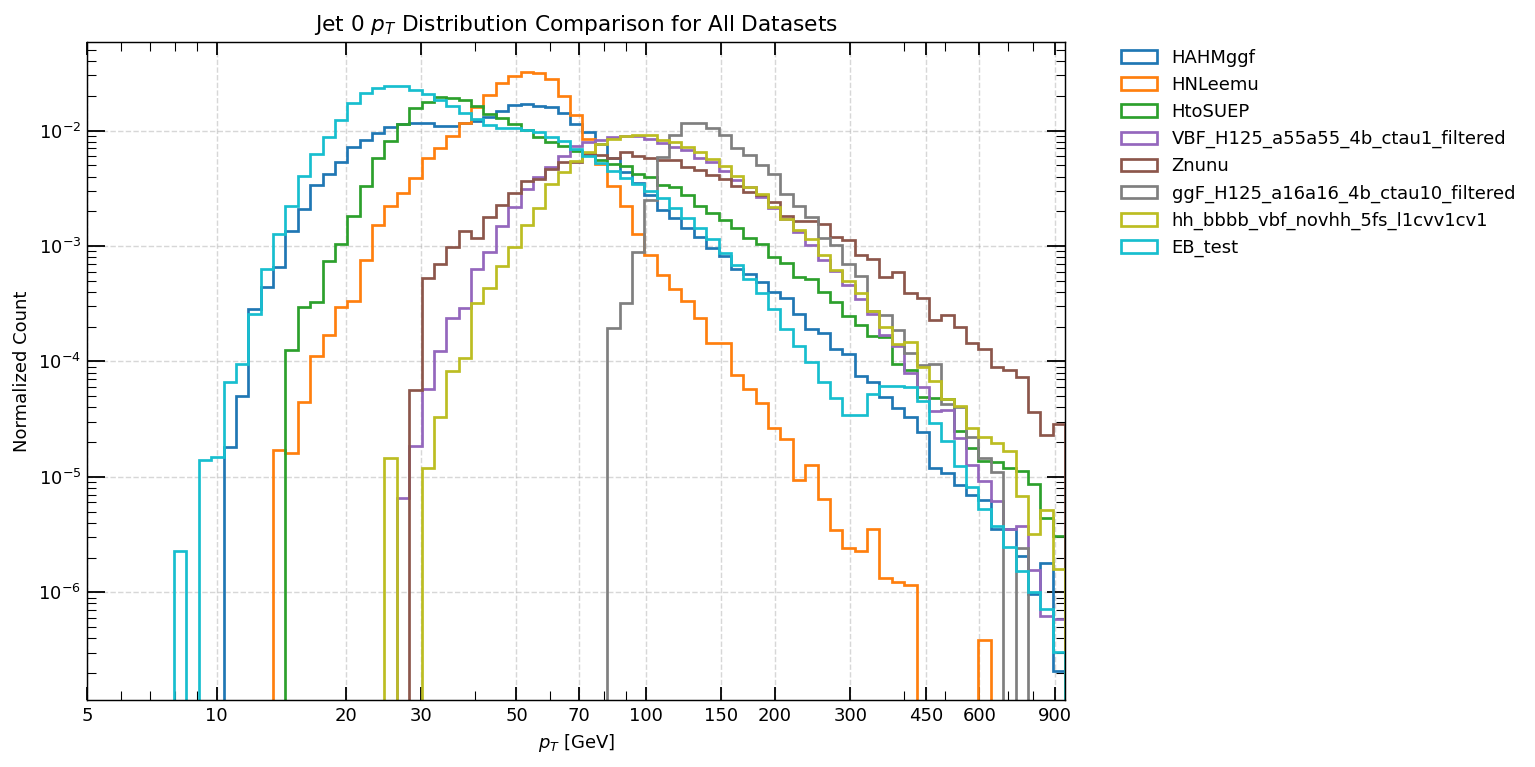

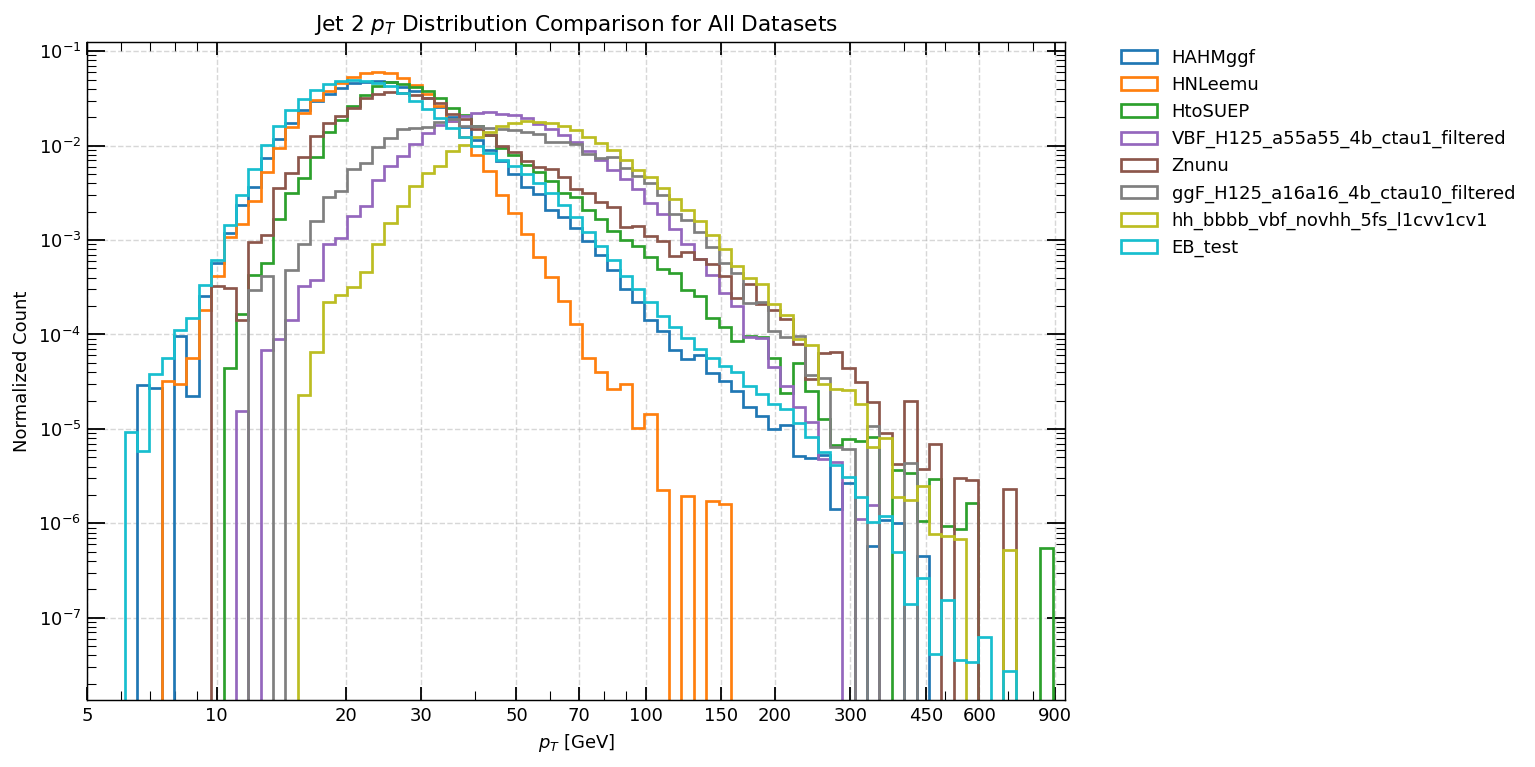

In [42]:
# Example usage with log scale enabled
plot_jet_pt_comparison(hlt_df_filtered_pt_cut,jet_indices=[0,2], log_y=True)

In [43]:
# Combine all filtered dataframes into a single dataframe for easier plotting
filtered_df = pd.concat(hlt_df_filtered_pt_cut.values(), ignore_index=True)

In [44]:
def plot_original_vs_filtered_aggregated(column_names, original_df, filtered_df, target_value=None, log_y=False, bins=100):
    """
    Plots the distribution of specified columns, comparing the entire original hlt_df
    with the entire aggregated filtered dataframe (combined_filtered_df),
    optionally filtered by a 'target' value.

    Args:
        column_names (list of str): A list of column names to plot (e.g., ['j0pt', 'e0eta']).
        original_df (pd.DataFrame): The original combined HLT dataframe (`hlt_df`).
        filtered_df (pd.DataFrame): The aggregated filtered dataframe (`combined_filtered_df`).
        target_value (str, optional): If provided, filters both dataframes by this value
                                       in the 'target' column before plotting. Defaults to None.
        log_y (bool): If True, use a logarithmic scale for the y-axis. Defaults to False.
        bins (int): Number of bins for the histogram. Defaults to 50.
    """
    if target_value:
        original_df_subset = original_df[original_df['target'] == target_value].copy()
        filtered_df_subset = filtered_df[filtered_df['target'] == target_value].copy()
        plot_title_suffix = f' for {target_value}'
    else:
        original_df_subset = original_df.copy()
        filtered_df_subset = filtered_df.copy()
        plot_title_suffix = ''

    for column_name in column_names:
        print(f"Plotting {column_name} distribution comparison (Original Aggregated vs. Filtered Aggregated){plot_title_suffix}...")

        # Determine histogram bins
        if 'pt' in column_name:
            bin_edges = np.logspace(np.log10(1), np.log10(250), bins)
        else:
            bin_edges = bins

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # --- Extract data from original_df ---
        data_original = original_df_subset[column_name]
        if 'pt' in column_name:
            # For pT columns, consider only values > 0 for a meaningful comparison,
            # as filtered data explicitly removes events with pT <= 5.
            data_original = data_original[data_original > 0]

        ax.hist(data_original, bins=bin_edges, color='blue',
                label='Original (Raw)', histtype='step', density=False, linewidth=1.5, alpha=0.7)

        # --- Extract data from filtered_df ---
        data_filtered = filtered_df_subset[column_name]
        # Filter >0 for consistency across all columns, though pT > 5 already applies to filtered_df
        if 'pt' in column_name:
            data_filtered = data_filtered[data_filtered > 0]

        ax.hist(data_filtered, bins=bin_edges, color='red',
                label='Filtered (Dupl. Removed & pT > 5 GeV)', histtype='step', density=False, linewidth=1.5, linestyle='--', alpha=0.7)

        ax.set_title(f'Distribution of {column_name} (Original vs. Filtered){plot_title_suffix}')
        ax.set_xlabel(column_name)
        ax.set_ylabel('Count')

        # Determine x_range based on column type
        x_range = None
        if 'pt' in column_name:
            if 'METpt' in column_name:
                x_range = (0, 300) # MET can go higher
            else:
                x_range = (0, 250)
        elif 'eta' in column_name:
            x_range = (-5, 5)
        elif 'phi' in column_name:
            x_range = (-np.pi, np.pi)

        if x_range:
            ax.set_xlim(x_range[0], x_range[1])
        # else: for other columns, Matplotlib's auto-ranging is fine.

        if log_y:
            ax.set_yscale('log')

        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper right', fontsize=12) # Increased font size of legend

        plt.tight_layout()
        plt.show()

Plotting j0pt distribution comparison (Original Aggregated vs. Filtered Aggregated) for EB_test...


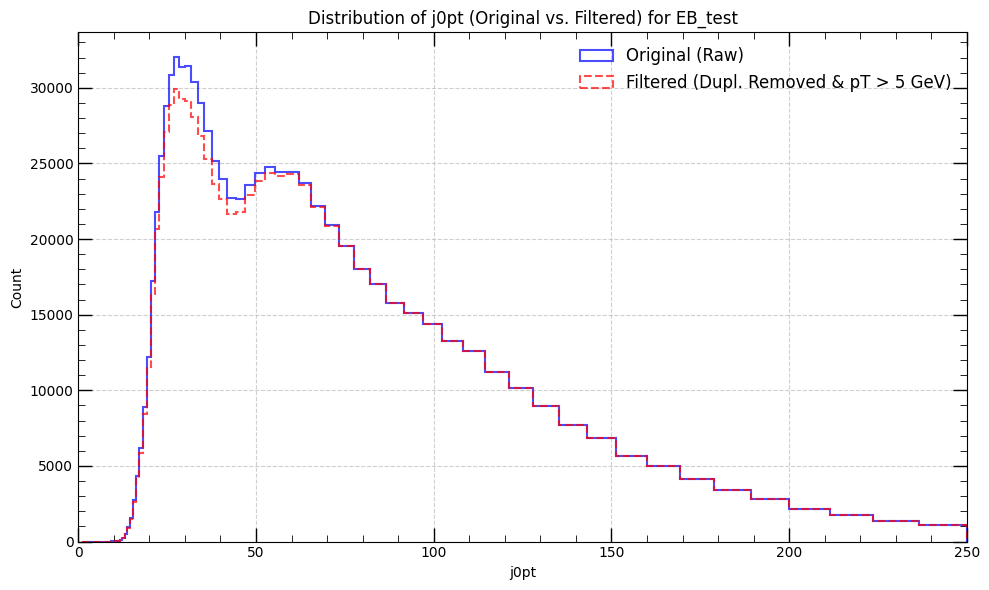

Plotting e0pt distribution comparison (Original Aggregated vs. Filtered Aggregated) for EB_test...


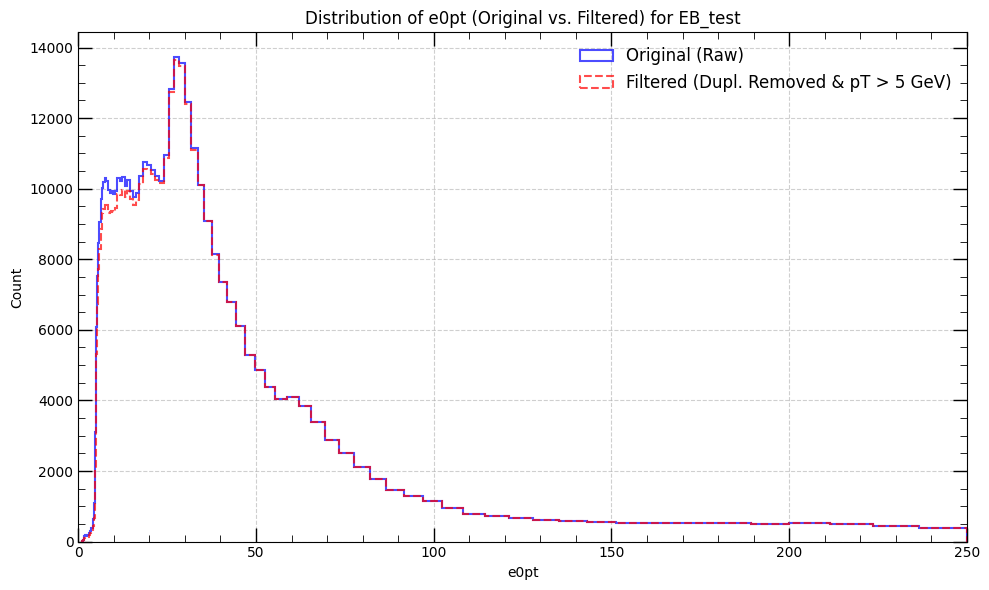

Plotting ph0pt distribution comparison (Original Aggregated vs. Filtered Aggregated) for EB_test...


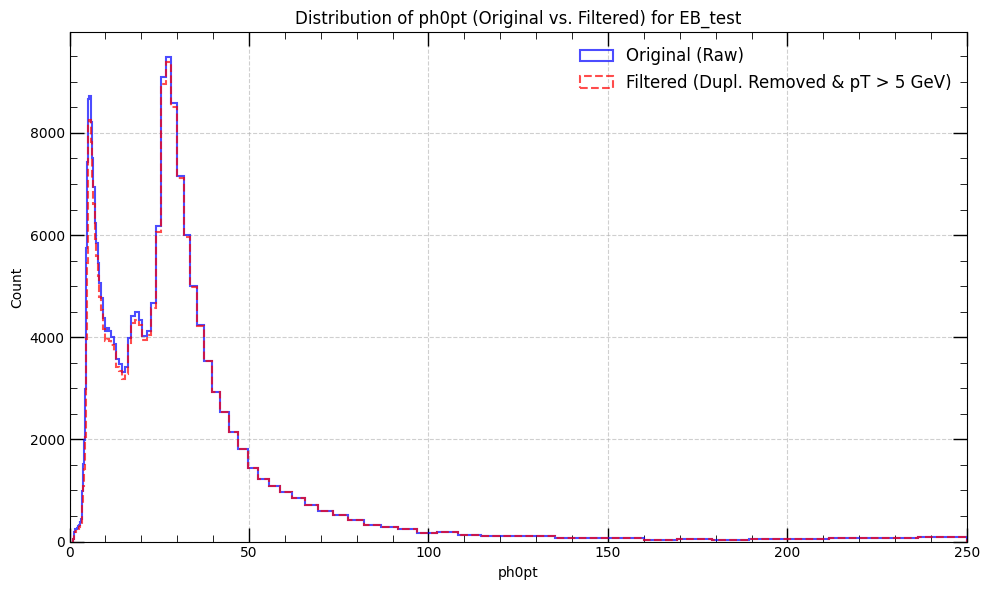

Plotting j0eta distribution comparison (Original Aggregated vs. Filtered Aggregated) for EB_test...


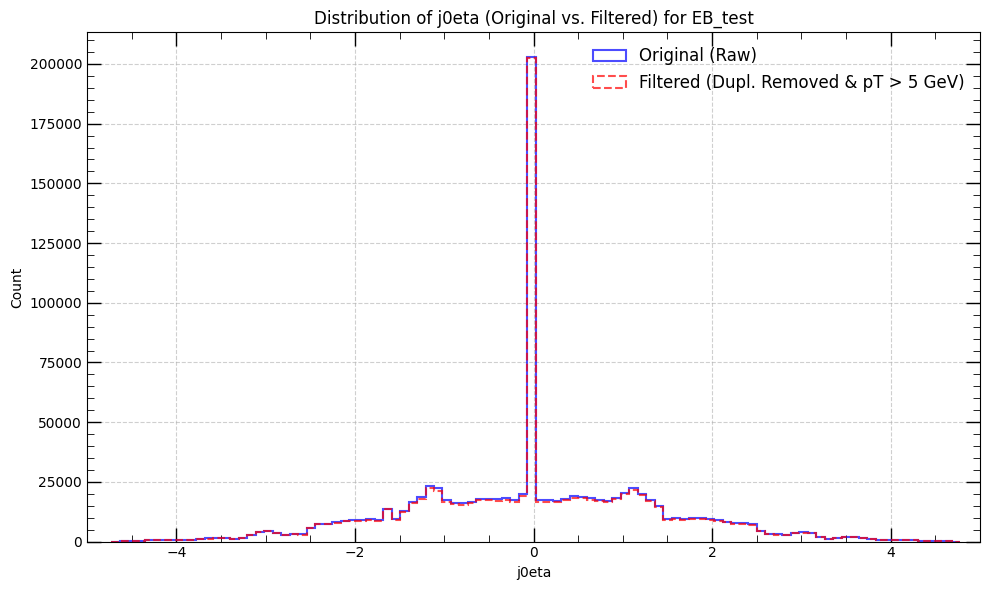

Plotting j0phi distribution comparison (Original Aggregated vs. Filtered Aggregated) for EB_test...


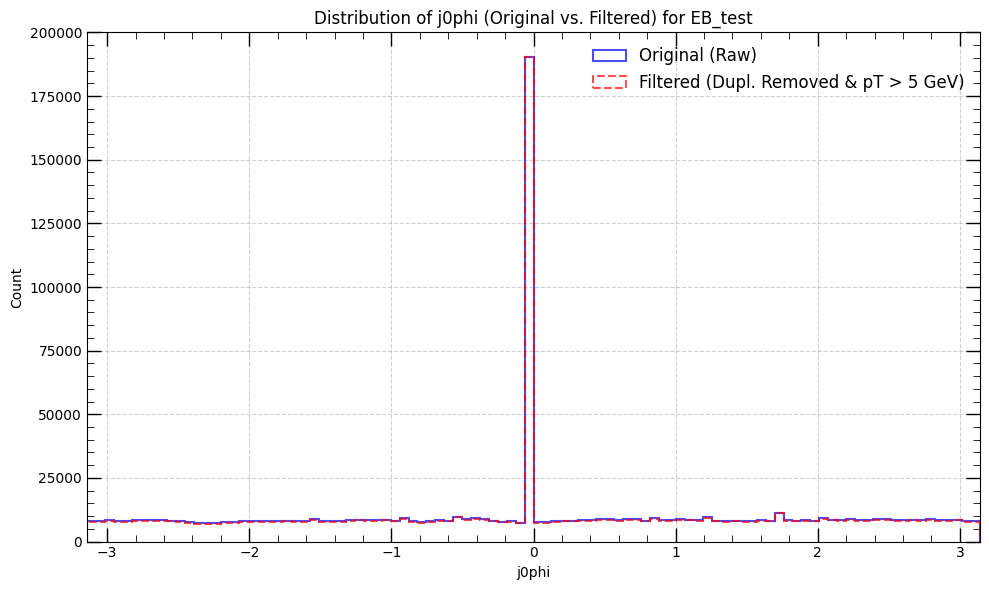

In [45]:
# Example usage:
# Some representative kinematic columns for comparison
columns_to_compare = ['j0pt', 'e0pt', 'ph0pt', 'j0eta', 'j0phi']

plot_original_vs_filtered_aggregated(columns_to_compare, hlt_df, filtered_df, target_value='EB_test', log_y=False)

### Jet Kinematic Distributions (after 5 GeV pT cut)

Let's visualize the distributions of transverse momentum ($p_T$), pseudorapidity ($\eta$), and azimuthal angle ($\phi$) for the leading jets (j0 and j1). We will compare the 'EB_test' dataset with the 'All signals combined' dataset.

In [46]:
def plot_jet_kinematics(df, dataset_name, jet_indices=[0, 1, 2]):
    """
    Plots pT, eta, and phi distributions for specified leading jets in a dataset.
    """
    print(f"Plotting jet kinematics for {dataset_name}")
    fig, axes = plt.subplots(len(jet_indices), 3, figsize=(18, 6 * len(jet_indices)))
    if len(jet_indices) == 1: # Handle single jet case for axes indexing
        axes = [axes]

    for i, j_idx in enumerate(jet_indices):
        jet_pt_col = f'j{j_idx}pt'
        jet_eta_col = f'j{j_idx}eta'
        jet_phi_col = f'j{j_idx}phi'

        # Filter out zero-pT jets if not already handled by previous cuts
        df_jet = df[df[jet_pt_col] > 0]

        # Plot pT
        axes[i][0].hist(df_jet[jet_pt_col], bins=100, color='skyblue', histtype='step')
        axes[i][0].set_title(f'{dataset_name}: Jet {j_idx} $p_T$ Distribution')
        axes[i][0].set_xlabel('$p_T$ [GeV]')
        axes[i][0].set_ylabel('Count')
        axes[i][0].set_xlim(-1, 250)

        # Plot eta
        axes[i][1].hist(df_jet[jet_eta_col], bins=50, color='green', histtype='step')
        axes[i][1].set_title(f'{dataset_name}: Jet {j_idx} ' + r'$\eta$' + ' Distribution')
        axes[i][1].set_xlabel(r'$\eta$')
        axes[i][1].set_ylabel('Count')

        # Plot phi
        axes[i][2].hist(df_jet[jet_phi_col], bins=50, color='red', histtype='step')
        axes[i][2].set_title(f'{dataset_name}: Jet {j_idx} ' + r'$\phi$' + ' Distribution')
        axes[i][2].set_xlabel(r'$\phi$')
        axes[i][2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

In [47]:
# # Plot for EB_test
# plot_jet_kinematics(filtered_df[filtered_df['target'] == 'EB_test'], 'EB_test')

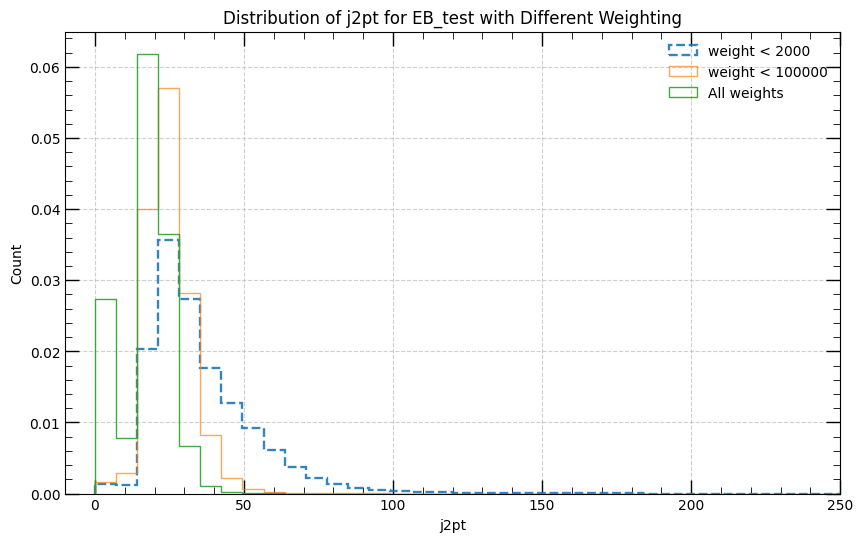

In [48]:
# Filter by target to get the base DataFrame for plotting all events
df_target = filtered_df[filtered_df['target'] == 'EB_test'].copy()

# Create weight arrays based on conditions
weights_all = df_target['weight'].values
weights_lt_2k = weights_all * (weights_all < 2000)
weights_lt_10k = weights_all * (weights_all < 100000)

# Determine binning
variable = 'j2pt'
nbins = 100
# Use the max value from the all weights data for binning
data_max = df_target[variable].max() if not df_target.empty else 0
if data_max > 0:
     bins = np.linspace(0, data_max, nbins + 1)
else:
     bins = nbins

# Create figure
plt.figure(figsize=(10, 6))

# Plot histograms using different weight arrays
plt.hist(df_target[variable], bins=bins, weights=weights_lt_2k, histtype='step', label='weight < 2000', alpha=0.9, density=True, linestyle='--', linewidth=1.7)
plt.hist(df_target[variable], bins=bins, weights=weights_lt_10k, histtype='step', label='weight < 100000', alpha=0.7, density=True)
plt.hist(df_target[variable], bins=bins, weights=weights_all, histtype='step', label='All weights', alpha=0.9, density=True)

# Option for log scale on y-axis
log_y = False  # Set to True to enable log scale, False for linear scale
if log_y:
    plt.yscale('log')
    plt.ylabel('Count (log scale)')
else:
    plt.ylabel('Count')
    plt.xlim(-10,250)


# Final formatting
plt.title(f'Distribution of {variable} for EB_test with Different Weighting')
plt.xlabel(variable)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [49]:
def make_balanced_samples(filtered_df):

    # Identify background and signals
    bkg = filtered_df[filtered_df["target"] == "EB_test"].copy()
    sig = filtered_df[filtered_df["target"] != "EB_test"].copy()

    results = {}

    # -----------------------------------------------------------
    # 1. Equal TOTAL number of signals (all combined) and background
    # -----------------------------------------------------------

    n_sig_total = len(sig)

    bkg_sample_total = bkg.sample(
        n=n_sig_total,
        weights=bkg["weight"],
        replace=False
    )

    results["all_signals"] = pd.concat(
        [sig, bkg_sample_total],
        ignore_index=True
    )

    # -----------------------------------------------------------
    # 2. Equal number of signal and background FOR EACH SIGNAL CLASS
    # -----------------------------------------------------------

    for cls, sig_cls_df in sig.groupby("target"):

        n_cls = len(sig_cls_df)

        bkg_sample = bkg.sample(
            n=n_cls,
            weights=bkg["weight"],
            replace=False
        )

        # Store each class with its own key (flat dictionary)
        results[cls] = pd.concat(
            [sig_cls_df, bkg_sample],
            ignore_index=True
        )

    return results


In [50]:
ML_dict = make_balanced_samples(filtered_df)

In [51]:
ML_dict.keys()

dict_keys(['all_signals', 'HAHMggf', 'HNLeemu', 'HtoSUEP', 'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu', 'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'])

In [52]:
ML_dict['HAHMggf'].shape

(156506, 52)

In [53]:
# import pickle

# with open("/content/drive/MyDrive/Datasets/balanced_dfs_no_dup_processed.pkl", "wb") as f:
#     pickle.dump(ML_dict, f)